In [1]:
!pip install tensorflow opencv-python matplotlib


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/93/21/9b035a4f823d6aee2917c75415be9a95861ff3d73a0a65e48edbf210cec1/tensorflow-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/c7/ec/9dabb6a9abfdebb3c45b0cc52dec901caafef2b2c7e7d6a839ed86d81e91/opencv_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.15.0 from https://files.pythonhosted.org/packages/4c/48/1a5a15517f18eaa4ff8d598b1c000300b20c1bb0e624539d702117a0c369/tensorflow_intel-2.15.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/a2/ad/e0d3c824784ff121c03cc031f944bc7e139a8f1870ffd2845cc2dd76f6c4/absl_py-2.1.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee25279

In [6]:
pip install pandas


Note: you may need to restart the kernel to use updated packages.


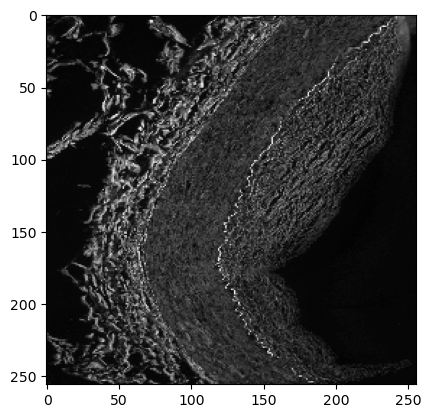

In [11]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Function to load and preprocess images
def load_and_preprocess_image(image_path, grayscale=False, target_size=(256, 256)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if not grayscale else image
    image = cv2.resize(image, target_size)
    return image

# Path to your image
image_path = 'C-8 Training Image.png'

# Load and preprocess the image in grayscale
image = load_and_preprocess_image(image_path, grayscale=True)

# Display the grayscale image
plt.imshow(image, cmap='gray')
plt.show()


In [13]:
import os
from PIL import Image

# Path to your image
image_path = 'C-8 Training Image.png'

# Open the input PNG image
input_image = Image.open(image_path)

# Define the size of each square (512x512)
square_size = 512

# Get the dimensions of the input image
width, height = input_image.size

# Calculate the number of rows and columns of squares
num_rows = height // square_size
num_cols = width // square_size

# Calculate the expected total number of patches
expected_patches = num_rows * num_cols

# Create a directory for the patched training images if it doesn't exist
output_dir = 'Patched Training Images'
os.makedirs(output_dir, exist_ok=True)

# Initialize a counter for the image names
image_counter = 1

# Loop through each row and column to crop and save the squares
for row in range(num_rows):
    for col in range(num_cols):
        left = col * square_size
        upper = row * square_size
        right = left + square_size
        lower = upper + square_size
        
        # Crop the square from the input image
        square = input_image.crop((left, upper, right, lower))
        
        # Save the square as a separate PNG file with the naming convention 'image_001.png', 'image_002.png', etc.
        file_name = f'image_{image_counter:03d}.png'
        square_path = os.path.join(output_dir, file_name)
        square.save(square_path)
        
        # Increment the image counter
        image_counter += 1

# Count the actual number of exported patches
actual_patches = image_counter - 1  # Subtract 1 to account for the initial counter value

print(f"Expected total patches: {expected_patches}")
print(f"Actual total patches exported: {actual_patches}")

if actual_patches == expected_patches:
    print("All patches successfully exported.")
else:
    print("Some patches may not have been exported.")

print(f"Squares extracted from '{image_path}' and saved in the '{output_dir}' folder with the specified naming convention.")


Expected total patches: 28
Actual total patches exported: 28
All patches successfully exported.
Squares extracted from 'C-8 Training Image.png' and saved in the 'Patched Training Images' folder with the specified naming convention.


In [32]:
import os
import cv2

# Define the path to your training data folder
data_folder = 'Ground Truthing Training Images'

# Initialize empty lists to store images and masks
images = []
masks = []

# Loop through files in the data folder
for filename in os.listdir(data_folder):
    if filename.startswith('image_'):
        # Load the image
        image_path = os.path.join(data_folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        images.append(image)
    elif filename.startswith('mask_'):
        # Load the corresponding mask
        mask_path = os.path.join(data_folder, filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        masks.append(mask)

# Convert the lists to numpy arrays
images = np.array(images)
masks = np.array(masks)


In [33]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)


In [34]:

# Define the folder containing images and masks
data_folder = 'Ground Truthing Training Images'

# Initialize a dictionary to store dimensions
dimensions_dict = {}

# Loop through files in the data folder
for filename in os.listdir(data_folder):
    if filename.startswith('image_'):
        # Load the image
        image_path = os.path.join(data_folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        dimensions_dict[filename] = image.shape
    elif filename.startswith('mask_'):
        # Load the corresponding mask
        mask_path = os.path.join(data_folder, filename)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        dimensions_dict[filename] = mask.shape

# Check if dimensions are consistent
unique_dimensions = set(dimensions_dict.values())

if len(unique_dimensions) == 1:
    print("Dimensions are consistent:", unique_dimensions)
else:
    print("Dimensions are not consistent:", unique_dimensions)


Dimensions are consistent: {(512, 512)}


In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
import numpy as np
from sklearn.model_selection import train_test_split

# Define the U-Net architecture with 512x512 output
def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder (contracting path)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Add more convolutional and pooling layers here...

    # Decoder (expansive path)
    up6 = UpSampling2D(size=(2, 2))(pool1)  # Upsample to match size

    # Add more upsampling and convolutional layers...

    # Output layer with 512x512 output shape
    out = Conv2D(1, 1, activation='sigmoid', padding='same')(up6)

    model = Model(inputs=inputs, outputs=out)
    return model

# Define the input shape as (512, 512, 1)
input_shape = (512, 512, 1)

# Split data
split = int(0.8 * len(images))
train_images, val_images = images[:split], images[split:]
train_masks, val_masks = masks[:split], masks[split:]

# Create the U-Net model
model = build_unet(input_shape)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the summary of the model
model.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 512, 512, 1)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 512, 512, 64)      640       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 256, 256, 64)      0         
 ng2D)                                                           
                                                                 
 up_sampling2d_10 (UpSampli  (None, 512, 512, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 512, 512, 1)       65        
                                                                 
Total params: 705 (2.75 KB)
Trainable params: 705 (2.75 KB)

In [36]:
print("Train Images Shape:", train_images.shape)
print("Train Masks Shape:", train_masks.shape)


Train Images Shape: (8, 512, 512)
Train Masks Shape: (8, 512, 512)


In [37]:
# Check data range for train_images
min_train_images = train_images.min()
max_train_images = train_images.max()

# Check data range for train_masks
min_train_masks = train_masks.min()
max_train_masks = train_masks.max()

# Print the data range
print("Train Images Data Range: Min={}, Max={}".format(min_train_images, max_train_images))
print("Train Masks Data Range: Min={}, Max={}".format(min_train_masks, max_train_masks))


Train Images Data Range: Min=2, Max=255
Train Masks Data Range: Min=0, Max=255


1/1 [==============================] - 0s 16ms/step


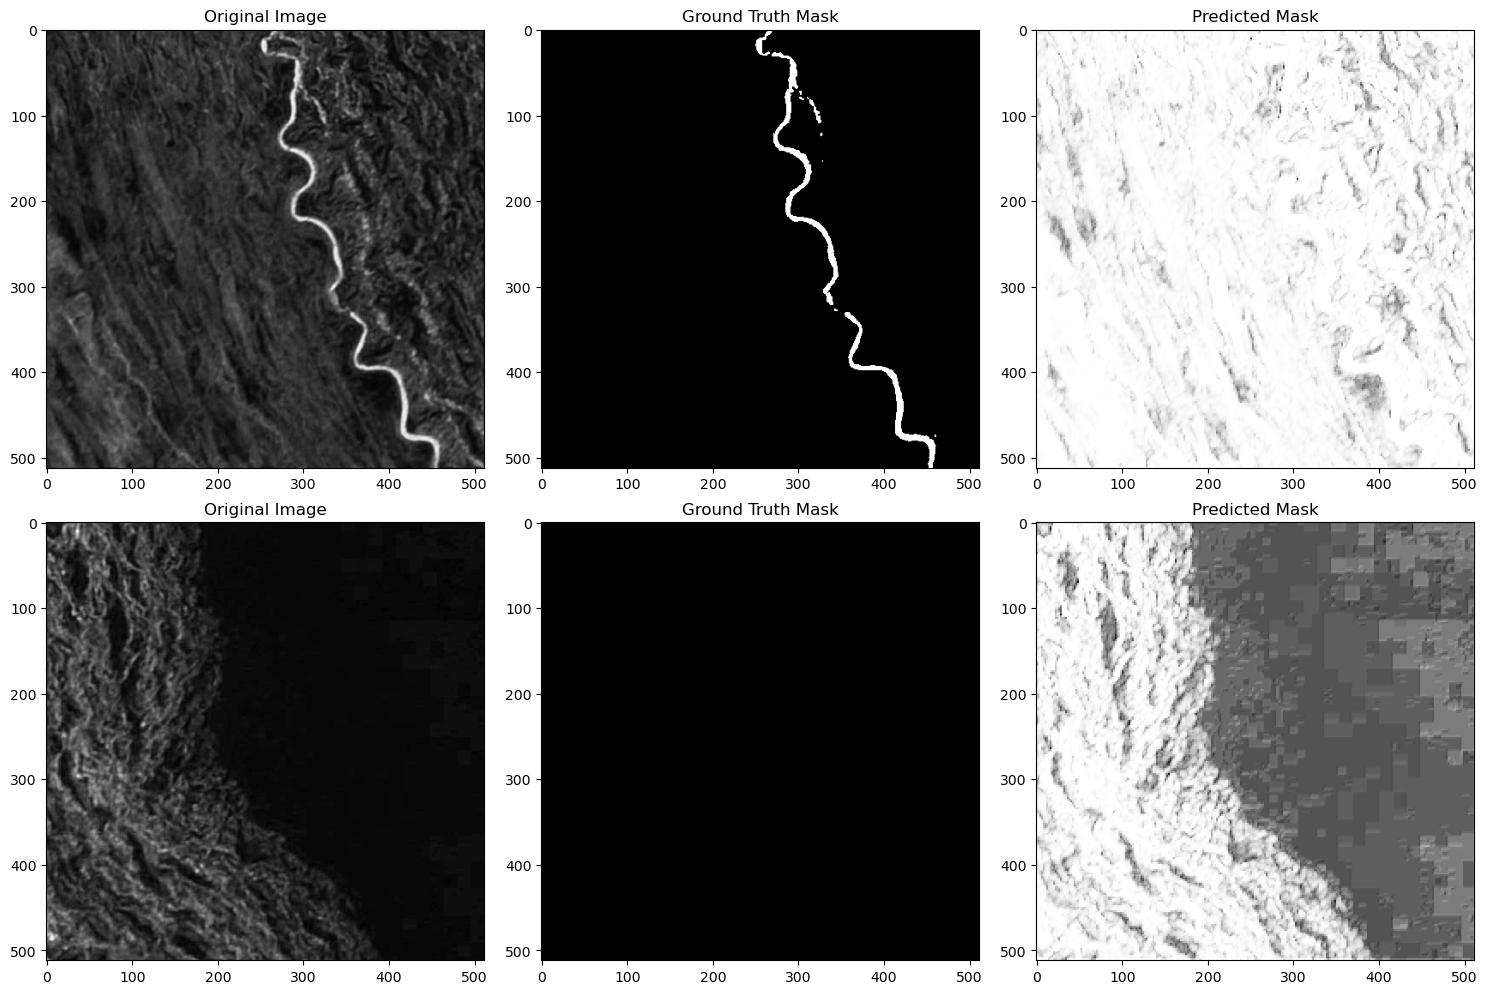

In [46]:
import matplotlib.pyplot as plt

# Define the number of rows and columns in the grid
num_rows = len(val_images)  # One row for each sample
num_columns = 3  # Three columns for original image, ground truth mask, and predicted mask

# Create a grid of subplots
fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5*num_rows))

# Iterate through all samples
for sample_index in range(len(val_images)):
    # Make predictions using the model
    predictions = model.predict(np.expand_dims(val_images[sample_index], axis=0))

    # Plot the original image
    axs[sample_index, 0].imshow(val_images[sample_index].squeeze(), cmap='gray')
    axs[sample_index, 0].set_title("Original Image")

    # Plot the ground truth mask
    axs[sample_index, 1].imshow(val_masks[sample_index].squeeze(), cmap='gray')
    axs[sample_index, 1].set_title("Ground Truth Mask")

    # Plot the predicted mask
    axs[sample_index, 2].imshow(predictions.squeeze(), cmap='gray')
    axs[sample_index, 2].set_title("Predicted Mask")

# Adjust spacing between subplots
plt.tight_layout()

# Show the grid of subplots
plt.show()
